In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df

,agency,observed_boardings,model_boardings,diff,perc_diff
2,King County Metro,"253,313.62","288,750.87","35,437.25",13.99%
5,Sound Transit,"113,374.00","126,233.62","12,859.62",11.34%
0,Community Transit,"25,962.00","20,876.15","-5,085.85",-19.59%
4,Pierce Transit,"21,185.00","16,689.78","-4,495.22",-21.22%
6,Washington Ferries,"9,278.21","8,406.43",-871.78,-9.40%
3,Kitsap Transit,"7,789.00","33,140.07","25,351.07",325.47%
1,Everett Transit,"4,201.00","2,452.87","-1,748.13",-41.61%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,973 W Sea Water Taxi,759.00,902.60,143.60,18.92%
1,975 Vashn Water Taxi,338.00,817.41,479.41,141.84%
2,WSF Edmonds-Kingston,"1,500.13",228.96,"-1,271.18",-84.74%
3,WSF Seattle-Bain Isl,"5,513.69","5,655.27",141.58,2.57%
4,WSF Seattle-Brem,"1,188.97",344.32,-844.65,-71.04%
5,WSF Fauntleroy-Swrth,142.56,519.96,377.40,264.73%
6,WSF Fauntleroy-Vashn,560.04,"1,422.47",862.42,153.99%
7,WSF Vashon-Southwrth,107.76,95.33,-12.43,-11.54%
8,WSF Pt Def-Tahlequah,265.05,140.12,-124.93,-47.13%


r^2 : 0.9272190340207095


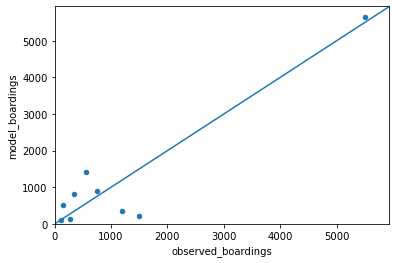

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Seattle-Kingston FF,722.50
2,4200,Seattle-Bremerton FF,419.80
3,4201,Brem-Pt Orchard FF,411.70
0,1973,973 W Sea Water Taxi,279.10
1,1975,975 Vashn Water Taxi,147.10
7,5002,WSF Seattle-Bain Isl,102.40
11,5007,WSF Pt Def-Tahlequah,65.00
10,5005,WSF Fauntleroy-Vashn,61.20
9,5004,WSF Fauntleroy-Swrth,32.20
8,5003,WSF Seattle-Brem,20.00


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","61,173.82","-18,348.18",-23.07%
1,Sounder South,"6,038.00","9,410.46","3,372.46",55.85%
2,Sounder North,316.00,13.86,-302.14,-95.61%


r^2 : 0.9969341653297217


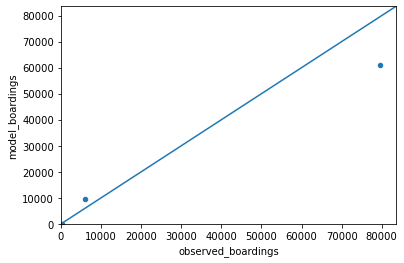

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","17,197.85","5,771.85",50.52%
4,C Line RapidRide,"7,250.00","13,259.45","6,009.45",82.89%
1,KC Metro 40,"7,208.00","10,607.78","3,399.78",47.17%
10,Sound Transit 550,"3,351.00","9,494.10","6,143.10",183.32%
0,KC Metro 7,"9,954.00","9,165.51",-788.49,-7.92%
5,D Line RapidRide,"9,044.00","8,101.41",-942.59,-10.42%
2,A Line RapidRide,"8,412.00","6,342.07","-2,069.93",-24.61%
7,F Line RapidRide,"4,748.00","4,899.04",151.04,3.18%
3,B Line RapidRide,"4,177.00","3,659.03",-517.97,-12.40%
9,First Hill Streetcar,"3,900.45",936.84,"-2,963.62",-75.98%


r^2 : 0.7465927724256375


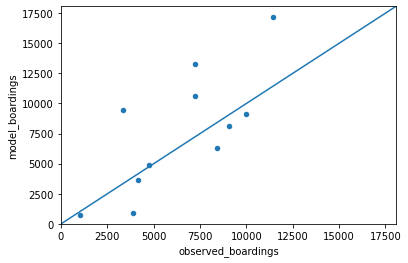

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.9328766813709843


r^2 Everett Transit: 0.9401297517175147
r^2 King County Metro: 0.8979341428674674
r^2 Kitsap Transit: 0.8590986465565857
r^2 Pierce Transit: 0.7554269977214172
r^2 Sound Transit: 0.985534493849471
r^2 Washington Ferries: 0.9335451439314667


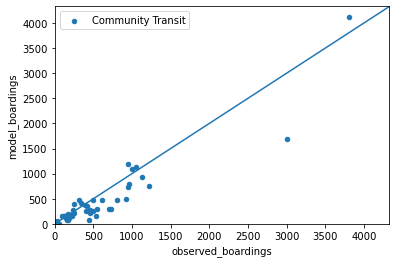

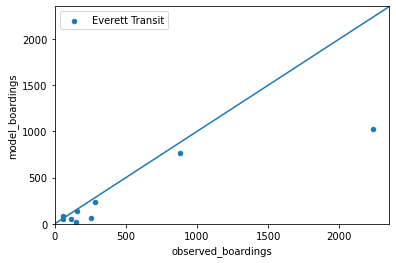

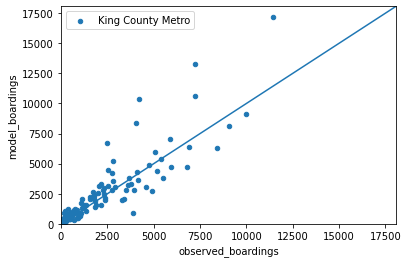

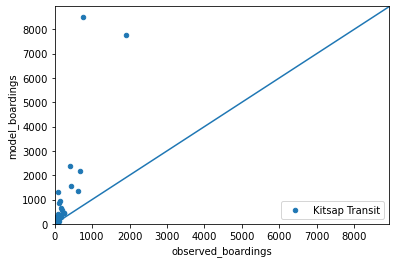

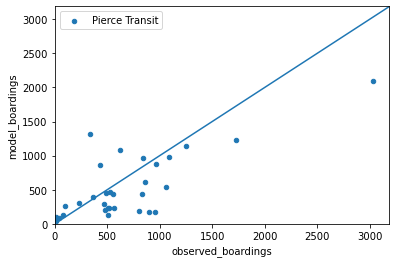

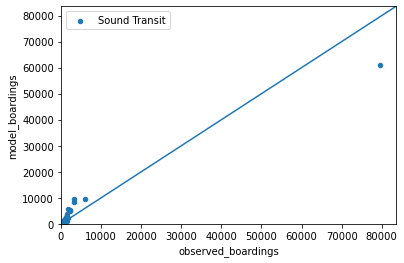

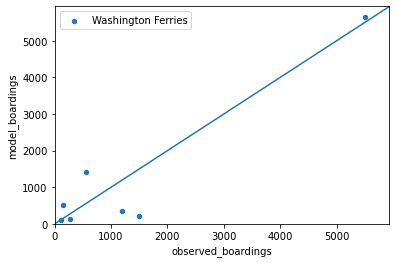

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","3,746.64","-2,387.36",-38.92%
Westlake,"8,845.00","7,353.49","-1,491.51",-16.86%
University St,"4,324.00","4,827.69",503.69,11.65%
Pioneer Square,"2,400.00","4,262.07","1,862.07",77.59%
Int'l District,"4,399.00","1,459.44","-2,939.56",-66.82%
Capitol Hill,"7,667.00","4,837.06","-2,829.94",-36.91%
Stadium,"1,731.00",437.83,"-1,293.17",-74.71%
SODO,"1,669.00","2,425.89",756.89,45.35%
Beacon Hill,"2,147.00",802.17,"-1,344.83",-62.64%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","3,746.64","-2,387.36",-38.92%
Capitol Hill,"7,667.00","4,837.06","-2,829.94",-36.91%
Westlake/University St,"13,169.00","12,181.19",-987.81,-7.50%
Pioneer Square/Int'l District,"6,799.00","5,721.51","-1,077.49",-15.85%
Stadium/SODO,"3,400.00","2,863.73",-536.27,-15.77%
Beacon Hill/Mount Baker,"4,008.00","1,744.10","-2,263.90",-56.48%
Columbia City,"1,630.00",895.05,-734.95,-45.09%
Othello/Rainier Beach,"3,525.00","1,957.97","-1,567.03",-44.45%
Tukwila Int'l Blvd,"2,298.00","1,618.95",-679.05,-29.55%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.92,-99.00,99.92,-100.93%
Westlake,0.15,0.36,-0.21,-57.68%
University St,0.23,0.20,0.03,15.78%
Pioneer Square,0.47,0.16,0.31,195.08%
Int'l District,0.68,0.45,0.23,51.89%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.23,0.12,0.11,92.66%
SODO,0.46,0.31,0.15,47.23%
Beacon Hill,0.33,0.35,-0.02,-6.32%
